In [1]:
import sys
sys.path.append('../reconstruct_missing_data')

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    create_missing_mask, 
    split_and_scale_data, 
    eof_weights, 
    get_land_silhouette,
)

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
from pathlib import Path
from json import dump, load
import os

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [11]:
## Specify experiment to reload results from:

# Set run name:
run = 'run_3'

# Get path to store results to:
path_to_store_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_realworld_DINEOF/'+run)

# Reload parameters for this experiment:
with open(path_to_store_results / 'parameters.json', 'r') as f:
    parameters=load(f)
    
# Specify experiment:
feature = parameters['feature']
feature_short = parameters['feature_short']
source =parameters['source']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
augmentation_factor = parameters['augmentation_factor']
train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']

# Specify time steps, lat and lon dimensions:
n_time = parameters['n_time']
n_lat = parameters['n_lat']
n_lon = parameters['n_lon']

# Specify number of EOFs to consider for reconstruction:
n_eof = parameters['n_eof']

# Specify max. number of iterations:
n_iter = parameters['n_iter']

# Set further parameters:
seed = parameters['seed']
seed_reserved = parameters['seed_reserved']
missing = parameters['missing']
reserved = parameters['reserved']

In [12]:
## Load data, including ALL features and mask for Ocean values:

if source=='realworld':
    
    # Specify path to data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"
    
    # Open data set:
    slp_dataset=xr.open_dataset(path_to_data)

    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    slp_fields = (
        slp_dataset.pres
        .sel(time=slice('1948-01-01', '2022-12-01'))
    )

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    slp_climatology_fields = (
        slp_dataset.pres
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields
    
    # When working with complete samples in spatial extend:
    # Remove last row (latidute), to have even number of steps in latitude (=72). This served as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    # This step is not essential for EOF, but keep it similar to U-Net approach.
    feature_anomaly = slp_anomaly_fields.values[:n_time,:n_lat,:n_lon]
    
    # Flatten spatial dimensions.
    feature_anomaly_flat = feature_anomaly.reshape((n_time,-1))

    # Remove mean over time, so that every grid point's values have zero mean over time.
    feature_anomaly_flat_zeromean = feature_anomaly_flat - np.mean(feature_anomaly_flat,axis=0)

else:

    # Specify path to data: 
    data_path='climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=data_path, data_source_name=source)

    # Extract feature:
    feature_raw = data[feature]
    
    # Remove seasonal cycle to get anomalies, use whole time span as climatology:
    climatology = feature_raw.groupby("time.month").mean("time")
    feature_anomaly = (feature_raw.groupby("time.month") - climatology).drop("month")[:n_time,:n_lat,:n_lon]
    
    # Flatten spatial dimensions.
    feature_anomaly_flat = feature_anomaly.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

    # Remove mean over time, so that every grid point's values have zero mean over time.
    # Additionally extract values, to have np.array:
    feature_anomaly_flat_zeromean = (feature_anomaly_flat - feature_anomaly_flat.mean(axis=0)).values
    
    

# Get missing mask, fitting to flat feature anomaly with zero mean.
# Missing grid points are masked as 'False'.
missing_mask = create_missing_mask(
    data=feature_anomaly_flat_zeromean, 
    mask_type=mask_type, 
    missing_type=missing_type, 
    missing_min=missing,
    missing_max=missing,
    seed=seed).astype('bool')

# Get mask for grid points that are reserved for cross-validation, fitting to flat feature anomaly with zero mean.
# To reach the specified 'reserved' rate, need to take the rate of missing values into account.
# Reserved grid points are masked as 'False'.
reserved_mask = create_missing_mask(
    data=feature_anomaly_flat_zeromean, 
    mask_type=mask_type, 
    missing_type=missing_type, 
    missing_min=reserved/(1-missing),
    missing_max=reserved/(1-missing),
    seed=seed_reserved).astype('bool')

# Now combine both masks to have reserved_gridpoints as subset of valid grid points (not missing!):
reserved_gridpoints = (reserved_mask==0) * (missing_mask==1)

# And derive missing_gridpoints, for convenience:
missing_gridpoints = (missing_mask==0)

# Set missing values to zero:
feature_anomaly_flat_zeromean_missing = feature_anomaly_flat_zeromean * missing_mask

In [13]:
# Reload losses and reconstructions:

total_loss=np.load(path_to_store_results / 'total_loss.npy')
reserved_loss=np.load(path_to_store_results / 'reserved_loss.npy')
missing_loss=np.load(path_to_store_results / 'missing_loss.npy')
abs_reconstruction=np.load(path_to_store_results / 'abs_reconstruction.npy')

feature_anomaly_flat_zeromean_missing_filename = 'feature_anomaly_flat_zeromean_missing_'+str(n_iter)+'_iterations.npy'
feature_anomaly_flat_zeromean_missing_final = np.load(
    path_to_store_results / feature_anomaly_flat_zeromean_missing_filename
)

print(len(total_loss))

1000000


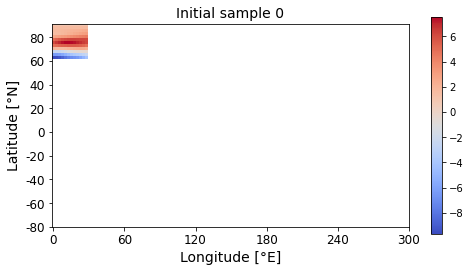

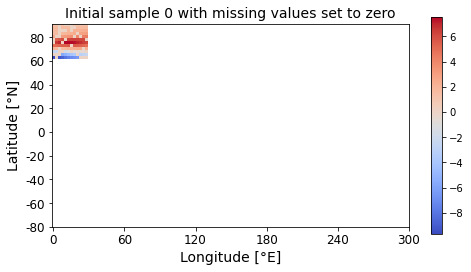

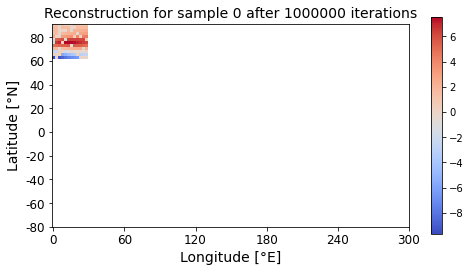

In [19]:
# Pick sample:
i=0

# Plot initial flat feature anomaly with zero mean:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean[i].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Initial sample '+str(i), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot initial flat feature anomaly with zero mean and missing values set to zero:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean_missing[i].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Initial sample '+str(i)+' with missing values set to zero', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot reconstruction of flat feature anomaly after n_iter iterations:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean_missing_final[i].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Reconstruction for sample '+str(i)+' after '+str(n_iter)+' iterations', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [14]:
print('true summed abs. values of missing grid points: ',np.sum(np.abs(feature_anomaly_flat_zeromean[missing_gridpoints])))
print('reconstructed summed abs. values of missing grid points: ',np.sum(np.abs(feature_anomaly_flat_zeromean_missing_final[missing_gridpoints])))


true summed abs. values of missing grid points:  18507.113
reconstructed summed abs. values of missing grid points:  4.568509


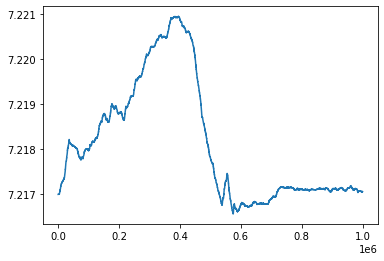

In [15]:
plt.plot(total_loss)


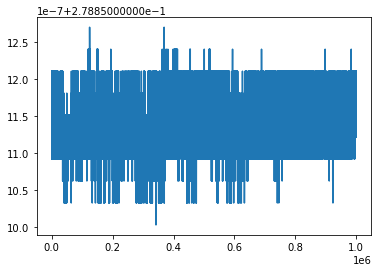

In [16]:
plt.plot(reserved_loss)

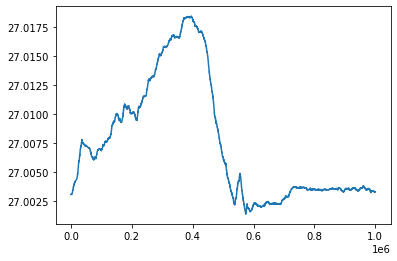

In [17]:
plt.plot(missing_loss)

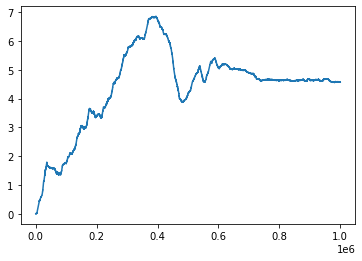

In [18]:
plt.plot(abs_reconstruction)